In [53]:
import numpy as np 
import scipy.optimize as optimize
import math 
import matplotlib.pyplot as plt     
from dotmap import DotMap
from legendre import legendre_polynomial,legendre_polynomial_dot, lagrange_polynomial, get_collocation
from utils import find_zeros,unique_with_tolerance #, unpack_coefficients

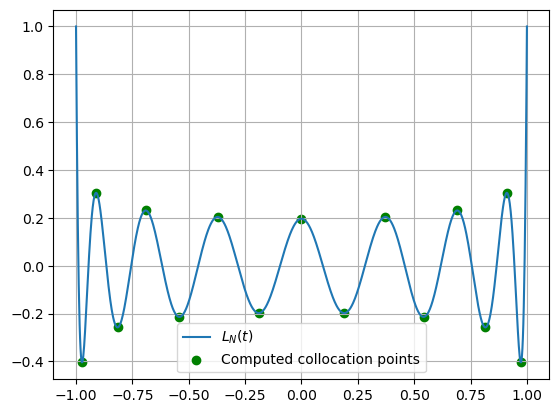

In [54]:
# Check correctness of legendre definitions
ps_N = 16
L_N = legendre_polynomial(n=ps_N)
L_N_dot = legendre_polynomial_dot(n=ps_N)


t_guess_array = np.linspace(start = -1,stop = 1, num= 100*ps_N, endpoint=False)
roots = unique_with_tolerance(find_zeros(L_N_dot,t_guess_array))

assert len(roots) == ps_N-1, f"Inconsistent size of collocation points {len(roots)} != {ps_N-1}"

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.linspace(-1,1,num=1000), L_N(np.linspace(-1,1,num=1000)), label = "$L_N(t)$")
ax.scatter(roots, L_N(roots), label= "Computed collocation points", c = 'green')
ax.grid(visible=True)
ax.legend()


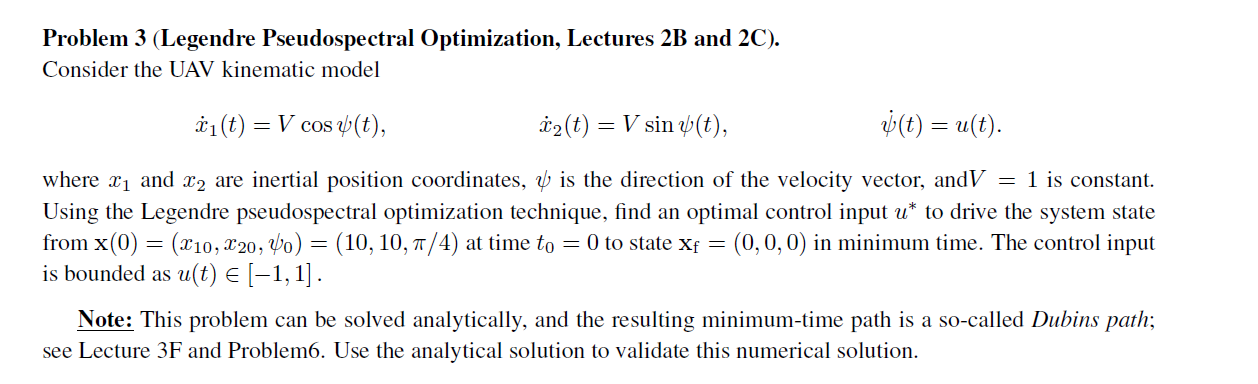

In [55]:
n_t_pts		= 10001;
# Choose order of Legendre polynomial
ps_N =9;	
LGL_colloc = get_collocation(ps_N=ps_N)
n_state	= 3 # Number of states
n_input	= 1 #Number of inputs
n_colloc	= ps_N + 1 # Number of collocation points
is_tf_free = 1
# Add 1 to number of decision variables if the final time tf is also to be optimized
n_decision_var	= (n_state + n_input)*(ps_N + 1) + is_tf_free #Total number of decision variables
print(n_decision_var)

V = 1 # m/s
# Boundary conditions 
x_init	= np.array([10,10,-math.pi]);
x_term	=np.array([0,0,0])

u_lower,u_upper = -1,1 # Inequality control constraints


41


In [56]:

def unpack_coefficients(
    q: np.ndarray, n_state: int, n_input: int, n_colloc: int
) -> tuple:
    a_ = np.zeros(
        (n_state, n_colloc)
    )  # These are the state coefficients a_k, i.e., the k_th column is a the k_th column is a_k
    b_ = np.zeros((n_input, n_colloc))
    end_indx = n_state * n_colloc
    for k in range(n_colloc):
        a_[:, k] = q[k:k+ n_colloc*(n_state):n_colloc]
    for k in range(n_colloc):
        b_[:, k] = q[
            (end_indx + n_input * k) : (end_indx + n_input * (k + 1)) # I think this is wrong but works for 1D input
        ]  # %Similarly, these are the input coefficients b_k
    return a_, b_


In [57]:
x = np.linspace(x_init[0], x_term[0], n_colloc)
y = np.linspace(x_init[1], x_term[1], n_colloc)
theta = np.linspace(x_init[2], x_term[2], n_colloc)
#x = [V*np.cos(theta[i+1]) for i in ran ]

# Initial guess for state coefficients
a_initial = np.vstack([x, y, theta])
print(a_initial[:,0])
# Initial guess for control coefficients (yaw rate)
b_initial = np.concatenate((np.zeros((n_input, int(n_colloc/2))),np.zeros((n_input, int(n_colloc/2)))))

# Pack the initial guess into the decision variable q
q_initial_guess = np.concatenate([a_initial.flatten(), b_initial.flatten()])
print(q_initial_guess)
print(len(q_initial_guess))
print(n_colloc*(n_state+n_input))
if is_tf_free: 
    # Allocate decision variable \tau_f and provide initial guess
    q_initial_guess = np.concatenate([q_initial_guess,[15]])

assert len(q_initial_guess) == n_decision_var
a,b = unpack_coefficients(q_initial_guess, n_state,n_input, n_colloc)

assert all([a_initial[i,0] == a[i,0] for i in range(3)])
print(a[:,1])
# print(b)


[10.         10.         -3.14159265]
[10.          8.88888889  7.77777778  6.66666667  5.55555556  4.44444444
  3.33333333  2.22222222  1.11111111  0.         10.          8.88888889
  7.77777778  6.66666667  5.55555556  4.44444444  3.33333333  2.22222222
  1.11111111  0.         -3.14159265 -2.7925268  -2.44346095 -2.0943951
 -1.74532925 -1.3962634  -1.04719755 -0.6981317  -0.34906585  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
40
40
[ 8.88888889  8.88888889 -2.7925268 ]


In [58]:
def plot_trajectory(a_):
    x = a_[:, 0]
    y = a_[:, 1]
    theta = a_[:, 2]  # Assuming the third state is heading (theta)
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', label='Trajectory')
    plt.scatter(x[0], y[0], color='red', label='Start')
    plt.scatter(x[-1], y[-1], color='green', label='End')
    plt.arrow(x[0], y[0], np.cos(theta[0]), np.sin(theta[0]), color='gray', head_width=0.2, head_length=0.3)
    plt.arrow(x[-1], y[-1], np.cos(theta[-1]), np.sin(theta[-1]), color='gray', head_width=0.2, head_length=0.3)
    for i in range(len(x)):
        if i%1000 == 0: 
            plt.arrow(x[i], y[i], np.cos(theta[i]), np.sin(theta[i]), color='gray', head_width=0.2, head_length=0.3)
    

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def plot_control(b_):
    plt.figure(figsize=(10, 6))
    plt.plot(LGL_colloc.t_grid, b_, 'b-', label='Trajectory')
    plt.xlabel('t')
    plt.ylabel('u')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

[1.00000000e+01 9.99224867e+00 9.98452581e+00 ... 7.75133475e-03
 7.07158727e-14 0.00000000e+00]


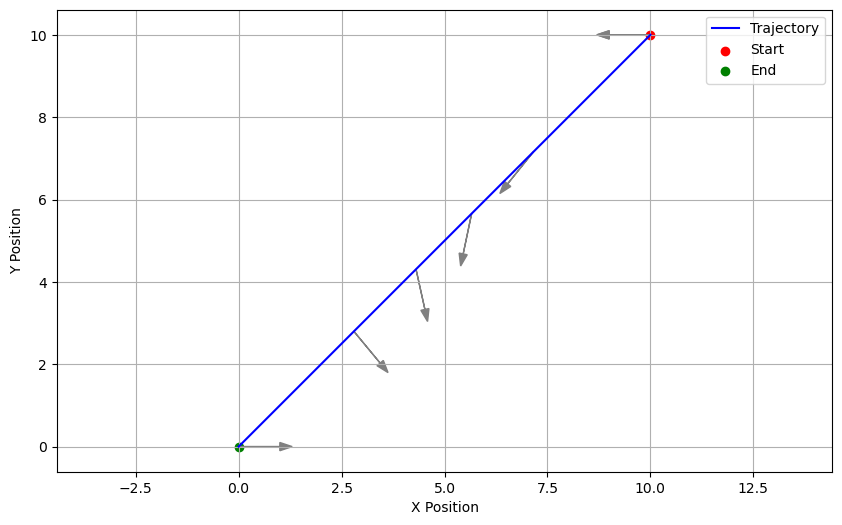

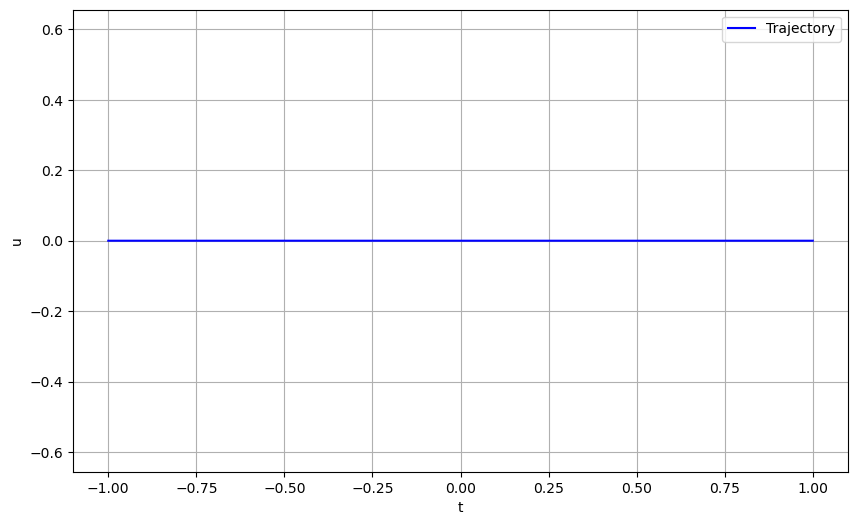

In [59]:
# Sanity check that lagrange reconstruction works as expected 
x_i	= np.dot(LGL_colloc.phi_l,a.transpose());
print(x_i[:,1])
u_i	= np.dot(LGL_colloc.phi_l, b.transpose());
plot_trajectory(x_i)
plot_control(u_i)

In [60]:

def system_dynamics_f(x_, u_):
	# Kinematics of Dubins problem 
	x_dot= [V*np.cos(x_[2]),V*np.sin(x_[2]), u_]
	return x_dot
print(system_dynamics_f(x_init,0))

def incremental_cost(x_,u_):
	return 1 # l == 1 when we only minimize time 

def calculate_cost(q: np.ndarray, n_state:int, n_input: int, n_colloc:int, tau_f = False) -> float:
    # Unpack parameters for readibility
	[a_, b_]= unpack_coefficients(q, n_state,n_input,n_colloc) 
	if not tau_f:
		# TODO: Should do some error catching here. 
		tau_f = q[-1]
	cost_J	= 0
	for k in range(n_colloc):
		w_k		= 2 / (ps_N*(ps_N + 1) * ( LGL_colloc.L_N_tm[k] )**2) # TODO: don't have this function call a global variable. prob just put everything in LGL
		cost_J +=  0.5*tau_f*w_k*incremental_cost(a_[:, k], b_[:, k]) 

	return cost_J


[-1.0, -1.2246467991473532e-16, 0]


The decision variable in the transcribed optimization problems is q = set of coefficients In normalized time, the i^th state $ x_i$  is
$x_i = \sum_{k=0}^{N} a_ki \phi_k$ and the i_th input is $u_i = \sum_{k=0}^{N} b_ki \phi_k$
We adopt the convention $q = (a_0, a_1, a_2, .. a_N, b_0, b_1, ... b_N)$  i.e., the vectors $a_k$ and $b_k$ stacked.


### Initial guess generation
There is no method of initial guess generation that works for all
systems. It is beneficial to find an initial guess that is feasible,
i.e., satisfies all constraints, or at least as many constraints as
possible. Here we set the states x_1 and x_2 to polynomial functions of
time and deduce the corresponding input u. This may not always be
possible to do, but it can be done for this particular system.


In [61]:

# CONSTRAINTS OF THE TRANSCRIBED PROBLEM
def calculate_constraints(q: np.ndarray, n_state:int, n_input: int, n_colloc:int, tau_f = False) -> tuple:
	a_, b_= unpack_coefficients(q, n_state,n_input,n_colloc)
	if not tau_f:
		# TODO: Should do some error catching here. 
		tau_f = q[-1]
	
	c_inequality= []
	c_equality	= []

	f_= np.zeros(( n_state, n_colloc) ) 
	for k in np.arange(n_colloc):
		# TODO: This can definitely be vectorized 
		f_[:, k] = system_dynamics_f(a_[:, k], b_[:, k] )
		
		c_inequality = np.concatenate((c_inequality, b_[:,k]- u_lower, b_[:,k]+u_upper))

	for n in range(n_state):
		c_equality_temp =  np.dot(LGL_colloc.D, (a_[n,:] - 0.5*tau_f*f_[n, :]))

		c_equality = np.concatenate([c_equality,c_equality_temp]) # Don't enforce system dynamics on prescribed boundaries
# 		%-----	Equality constraints arising from boundary conditions

	c_equality	= np.concatenate([ a_[:, 0] - x_init,c_equality, a_[:,-1] - x_term])
# 		c_equality	= [c_equality; a_(:, 1) - x_init];
		# Inequaloty constraints from upper and lower bounds
	#c_inequality = np.concatenate((c_inequality, [tau_f])) # Enforce positive time
	return c_equality,c_inequality
equality_constraints = lambda q:  calculate_constraints(q,n_state,n_input,n_colloc)[0]
inequality_constraints = lambda q:  calculate_constraints(q,n_state,n_input,n_colloc)[1]

a_, b_= unpack_coefficients(q_initial_guess, n_state,n_input,n_colloc)
# print()
print(equality_constraints(q_initial_guess))
# print(np.shape(q_initial_guess))
print(inequality_constraints(q_initial_guess))

[  0.           0.           0.         -23.81141494 -16.14155845
 -12.14387717 -11.66715013 -11.23758718 -11.23758718 -11.66715013
 -12.14387717 -16.14155845 -23.81141494  25.14785984  12.36646729
   3.16080832   1.19488417  -2.46181946  -4.25778762  -9.05002727
 -12.34912598 -31.72660217 -63.75100868   6.06376844   3.04108288
   1.44329756   1.23388299   1.05551341   1.05551341   1.23388299
   1.44329756   3.04108288   6.06376844   0.           0.
   0.        ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


C:\Users\tagren\AppData\Local\Temp\1\ipykernel_35192\2279952896.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  f_[:, k] = system_dynamics_f(a_[:, k], b_[:, k] )


In [72]:
# Optimize
objective = lambda q: calculate_cost(q,n_state,n_input,n_colloc)
print(objective(q_initial_guess))
options = {
    'maxiter': 1000  # Set the maximum number of iterations
}

result = optimize.minimize(objective, q_initial_guess, options = options, method = 'SLSQP', constraints =  [{"type": "eq", "fun": equality_constraints},{ "type": "ineq", "fun": inequality_constraints}])
print(result)
print(unpack_coefficients(result.x,  n_state,n_input,n_colloc))




15.0


C:\Users\tagren\AppData\Local\Temp\1\ipykernel_35192\2279952896.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  f_[:, k] = system_dynamics_f(a_[:, k], b_[:, k] )


 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 14.9999833469459
       x: [ 1.000e+01  5.386e+00 ...  1.627e+00  1.500e+01]
     nit: 105
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]
    nfev: 4875
    njev: 101
(array([[ 1.00000000e+01,  5.38637479e+00,  3.54216957e+00,
         1.23873373e+01,  9.40839257e+00,  9.03415343e-01,
         5.21090669e-01, -1.10950420e+01,  1.67108643e+00,
        -2.63925976e-16],
       [ 1.00000000e+01,  1.59680115e+01,  1.28470470e+01,
         4.31523668e+00,  3.93767546e+00,  2.50379760e+00,
        -3.08126739e+00, -4.63521616e+00, -2.83441443e+00,
         1.74289870e-15],
       [-3.14159265e+00, -3.79939197e+00, -3.25414735e+00,
        -1.25324086e+00, -1.35806157e+00, -1.82823159e+00,
        -1.37446911e+00, -2.17105632e+00, -6.38970763e-01,
        -3.59260796e-16]]), array([[1.62685662, 1.49260782, 1.51876506, 1.73901075, 1.67849253,
        1.56926101, 1.58322062, 1.43046675, 1

In [69]:
print(equality_constraints(result.x))

[ -1.21678129   0.05268914  -0.40599911  -1.2063259   -8.00170185
 -12.20963602  -9.53128049  -8.57568031  -8.65441283  -7.85404009
  -7.56872673  -4.07983122   0.01818419   0.3940017    0.44419635
  -2.07992827  -0.56458632   0.56741554  -0.95698554  -2.58514823
   1.6940149    6.01256863   0.55416299   0.26441817   0.1759483
   0.47515641   0.88456623   0.99359538   0.69951686   0.33997084
   0.11181417   0.03767922   0.23639197   0.38885768  -0.22748949
  -1.33967458]


C:\Users\tagren\AppData\Local\Temp\1\ipykernel_35192\2279952896.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  f_[:, k] = system_dynamics_f(a_[:, k], b_[:, k] )


In [70]:
a_initial,b_initial = unpack_coefficients(q_initial_guess,  n_state,n_input,n_colloc)
a_optimal, b_optimal = unpack_coefficients(result.x,  n_state,n_input,n_colloc)
x_ps_opt	= np.dot(LGL_colloc.phi_l ,a_optimal.transpose());
u_ps_opt	= np.dot(LGL_colloc.phi_l, b_optimal.transpose());
# tau_f = 

print(a_optimal[2,:])

[-3.54759176 -1.90865984 -2.95462599 -2.4438123  -0.10092076  0.30651613
  0.81723225 -1.24528988  0.36156892 -1.33967458]


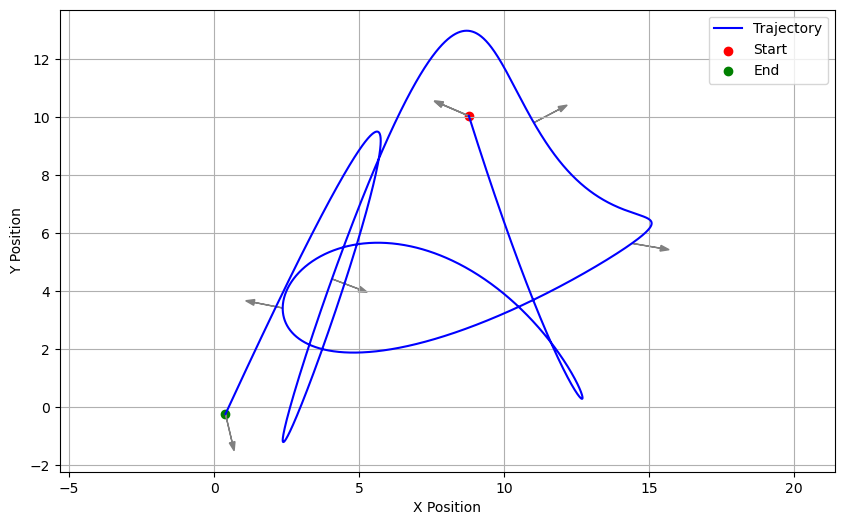

In [71]:

plot_trajectory(x_ps_opt)

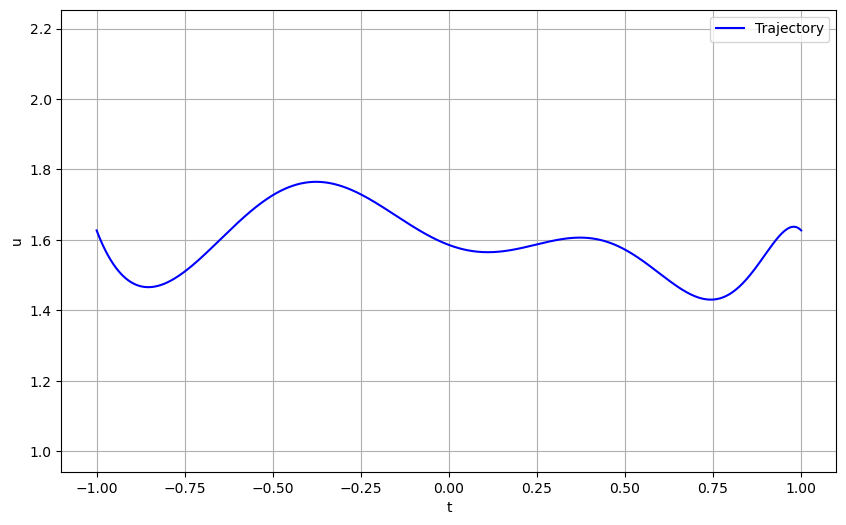

In [66]:
plot_control(u_ps_opt)